# Banana Collector

---

This notebook presents the work of training a Reinforcement Learning (RL) agent to navigate and collect bananas, in the Unity ML-Agents environment.



### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the instructions in `README` to setup the python environment.

In [12]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded, as instructed in the `README`.

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [13]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [14]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [15]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

Just for fun, in the next code cell, let's see what the agent does before it's trained.

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

### 4. Learning algorithm

To help the agent to collect more points (collect more yellow bananas while avoid blue ones), we are going to use Q learning and neural networks to design a smart brain for it.

[Q learning](https://en.wikipedia.org/wiki/Q-learning) is a technique to learn a policy (i.e., pick which action under which environment state) for Markove Decision Process (MDP). In a simple way, MDP states that for a given state `s` and an action in this state `a`, the next state `s'` depends on the current state `s` and action `a`. In RL problems, the agent also receives reward `r` when transitioning from `s` to `s'`. So the learning cycles of `(s, a, r, s')` pairs can be used to find a policy that optimizes the total reward (i.e., return). In q learning, it optimizes the decision making using the immediate reward and the maximum expected return.

Since the environment space (i.e., `state`) is a 37-dimensional continuous space. In order to better map a given state to an action, we also uses a neural network as function approximation. Neural network is able to make incredible prediction, by combining linear and non-linear functions. For this problem, we are going to have three hidden layers in the neural network, with 128, 64, 32 hidden units respectively. The input and output size of the network equal to the state size and action size respectively.

The hyperparameters are as below:
```
BUFFER_SIZE = int(1e5)  # replay buffer size for q learning agent
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-3               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
```

The whole architecture looks like below:

<img src="img/architecture.png" width="500">

### 5. Train the agent

Next let's use the defined model and q learning to train the model

In [16]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)


In [9]:
def dqn(n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = agent.act(state, eps)  # agent pick an action
            env_info = env.step(action)[brain_name]  # send the action to the environment
            next_state = env_info.vector_observations[0]  # get the next state
            reward = env_info.rewards[0]  # get the reward
            done = env_info.local_done[0]  # see if episode has finished

            agent.step(state, action, reward, next_state, done)  # agent update action values
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores


Episode 100	Average Score: 0.23
Episode 200	Average Score: 0.72
Episode 300	Average Score: 3.24
Episode 400	Average Score: 8.48
Episode 500	Average Score: 10.82
Episode 600	Average Score: 11.13
Episode 700	Average Score: 11.18
Episode 800	Average Score: 11.12
Episode 900	Average Score: 11.73
Episode 1000	Average Score: 11.69
Episode 1100	Average Score: 11.47
Episode 1200	Average Score: 11.25
Episode 1300	Average Score: 10.33
Episode 1400	Average Score: 12.23
Episode 1500	Average Score: 12.50
Episode 1520	Average Score: 13.05
Environment solved in 1420 episodes!	Average Score: 13.05


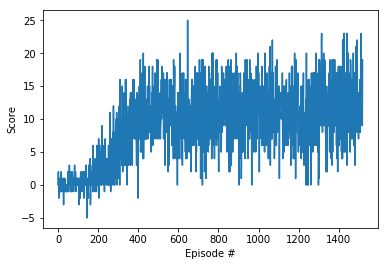

In [10]:
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Watch a Smart Agent!
Let's load the trained agent and see how it performs now.

In [26]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0

while True:
    action = agent.act(state)  # agent pick an action
    env_info = env.step(action)[brain_name]  # send the action to the environment
    next_state = env_info.vector_observations[0]  # get the next state
    reward = env_info.rewards[0]  # get the reward
    done = env_info.local_done[0]  # see if episode has finished

    state = next_state
    score += reward
    if done:
        break 

print("Score: {}".format(score))

Score: 18.0


In [27]:
env.close()

### 7. Improvements
There are a few improvements can be made, which may help the agent to learn faster!
1. Using Double DQN: During the training, especially in early stages, action with max q values can make a mistake when the agent hasn't experiences all of its neighbors in a given state. Instead of just selecting the best action for evaluating action values, DQN uses another weight matrix `w'` to evaluate the selected "best" action. In reality, we can use the `qnetwork_target` to help with the evaluation, rather than creating another new weight matrix.
2. Prioritized Experience Replay: It's reasonable to think that not all experiences have the same impacts on agent's learning process. Prioritized experience replay improves the agent exactly based on that. It uses `|TD Error|` as the priority for each experience. When it's time to learn, it samples based on the distribution of priorities.
3. Dueling DQN: in the original DQN as we used in the agent above, we directly predict the action values based on given state. What dueling DQN does differently is that, it make predictions on state values an advantage values first, then combine those two to return the final action values. In this way, we can assess the value of each state, without having to learn the effect of each action.